In [1]:
import os
import ee
import io
import PyIF
import tqdm
import json
import fiona
import random
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import seaborn as sns
import multiprocessing as mp

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from sklearn import metrics
from scipy import stats, spatial
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from matplotlib import gridspec, cm, animation
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from pandas.plotting import lag_plot

from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import warnings
warnings.filterwarnings('ignore')



/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# Relevant Equations (and refs)

#### Cross Correlation

of two signals is defined: 
 $[f*g](t) = \sum_{i=1}^{n} f(t) g(t-\tau)$

the characteristic time $\tau_{lag}$ can be computed: 

 $\tau_{lag} = argmax|[f*g](t)|$

#### Entropy (Shannon, 1948): 

Given a discrete random variable $X$, with possible outcomes $ x_{1},...,x_{n} $ which occur with probability $  \mathrm {P} (x_{1}),...,\mathrm {P} (x_{n}) $ the entropy (units of nats) of $X$ is defined as: <br>

$ H(X) =  - \sum_{i=1}^{n} P(x) \ln P(x) $

#### Joint Entropy:
of two discrete random variables $X$ and $Y$ is defined as the entropy of the joint distribution of $X$ and $Y$:

$ H(X,Y) =  - \sum_{i=1}^{n} P(x,y) \ln P(x,y) $


#### Conditional Entropy: 

The amount of information needed to describe the outcome of a random variable $Y$ given that the value of another random variable $X$ is known. Here, information is measured in shannons, nats, or hartleys. The entropy of $Y$ conditioned on $X$ is:

$ H (Y|X) = -\sum p(x,y)\ln {\frac {p(x,y)}{p(x)}} $


#### Relative Entropy, aka K-L Divergence,

The Relative Entropy (aka K-L divergence, $ D_{\text{KL}}(P\parallel Q)$ ), which measures how one probability distribution $P(x)$ is different from a second $Q(x)$ is defined as:

$ D_{\text{KL}}(P\parallel Q)=\sum _{x\in {\mathcal {X}}}P(x)\ln \left({\frac {P(x)}{Q(x)}}\right)$

#### Jensen Shannon Distance:

The Jensen Shannon Distance (JSD) also measures how one probability distribution $P(x)$ is different from a second $Q(x)$, but has desirable properties of always being finite and symmetric: 

$ JSD(X) = \sqrt{\frac{D(p \parallel m) + D(q \parallel m)}{2}}\$

where $D(x \parallel y)$ is the K-L Divergence, defined above.


#### Mutual information

measures how much information can be obtained about one random variable by observing another. The mutual information of $X$ relative to $Y$ (which represents conceptually the average amount of information about $X$ that can be gained by observing $Y$ is given by:

$ I(X; Y)=H(X)− H(X|Y)= -\sum p(x,y)\ln \frac{p(x,y)}{p(x) p(y)} $

#### Transfer entropy (Schreiber, 2000)

is the amount of directed (time-asymmetric) transfer of information between two random processes. Transfer entropy from a process X to another process Y is the amount of uncertainty reduced in future values of Y by knowing the past values of X given past values of Y.

$ T_{X→Y} = \sum p(y_{t+1}, y_{t}, x_{t}) ln( \frac{p(y_{t+1} | y_{t} , x_{t})} {p(y_{t+1} | y_{t})}) $

Can be thought of as the deviation from independence
(in bits) of the state transition (from the previous state
to the next state) of an information destination X from
the (previous) state of an information source Y

Transfer entropy can be thought of as Conditional mutual Information (Lizier, 2008): 

$ T_{X→Y} = I(X ; Y{t+1}|Y) = H(Y_{t+1}|Y) − H(Y_{t+1}|Y,X) $ 

#### References

Shannon, C. E. (1948). A mathematical theory of communication. The Bell system technical journal, 27(3), 379-423.

Schreiber, T. (2000). Measuring information transfer. Physical review letters, 85(2), 461.

Lizier, J. T., Prokopenko, M., & Zomaya, A. Y. (2008). Local information transfer as a spatiotemporal filter for complex systems. Physical Review E, 77(2), 026110.

In [2]:
# Functions

def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/SNODAS/SNODAS_CA_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - daily SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_data(stid, startdate, enddate, freq = 'D', var = 'inflow'):
    '''
    Fetch CDEV reservoir data via api 
    Input Params: 
        stid (str) - 3 letter station id (ex: ISB)
        startdate - 'YYYY-mm-dd'
        startdate - 'YYYY-mm-dd'
        freq - "D" = Day, "M" = Month
    
    Output: inflow - (pd.DataFrame)
    '''
    varlookup = {
                    'storage':'65',
                    'inflow':'76'}
    
    # build the api query from params
    query = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums={}&dur_code={}&Start={}&End={}'''.format(stid,varlookup[var],freq,startdate,enddate)
    print(query)
    # Read, extract relevant cols as float and datetime, return df
    dat = pd.read_csv(query)
    vals = pd.to_numeric(dat['VALUE'], errors = 'coerce')
    dt = pd.to_datetime(dat['DATE TIME'])
    indf = pd.DataFrame(zip(dt,vals* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return indf

def normalize(x):
    return(x-np.nanmin(x))/(np.nanmax(x)- np.nanmin(x))


def dict2im(outdict, empty_im, rclist=None):
    outim = np.zeros_like(empty_im)
    outdf = pd.DataFrame.from_dict(outdict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
        
    return outim

def make_lag_plots(shed_df, lag = 1):
    
    f1, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))

    lag_plot(shed_ts['q_cms'], lag = lag, ax=ax1)
    ax1.set_title('inflow');

    lag_plot(shed_ts['prcp'], lag = lag, ax=ax2)
    ax2.set_title('Prcp');

    lag_plot(shed_ts['swe'], lag = lag, ax=ax3)
    ax3.set_title('swe');

    lag_plot(shed_ts['dswe'], lag = lag, ax=ax4)
    ax4.set_title('dswe');
    f1.suptitle("{} day lag".format(str(lag)), size =30, y=1.07)
    f1.tight_layout()

    return plt.show()


def calc_nbins(N):
    
    '''
    A. Hacine-Gharbi, P. Ravier, "Low bias histogram-based estimation of mutual information for feature selection", Pattern Recognit. Lett (2012).
    '''
    ee = np.cbrt(8 + 324*N + 12*np.sqrt(36*N + 729*N**2))
    bins = np.round(ee/6 + 2/(3*ee) + 1/3)

    return int(bins)

def split_before_after(imstack, beforeidx,afteridx):
    beforeim = imstack[:,:,:beforeidx]
    afterim = imstack[:,:,-afteridx:]
    return beforeim, afterim

def mask_unpack(imlist, meanim):
    im1, im2, im3 = [np.ma.masked_array(x, mask=np.isnan(meanim)) for x in imlist]
    return im1, im2, im3

def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

def calc_info(imstack, inflow):
    
    # Build the out image
    te_im = np.zeros_like(np.mean(imstack, axis = 2))
    mi_im = np.zeros_like(np.mean(imstack, axis = 2))
    js_im = np.zeros_like(np.mean(imstack, axis = 2))

    rows, cols, time = imstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = imstack[row,col,:]
            if not np.isnan(ts_arr).all():
                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    if len(px_ts) == 0:
        return te_im, js_im, mi_im

    pxdf = pd.concat(px_ts, axis = 1)
    pxdf.columns = pxdf.columns.map(str)

    # Populate the per-pixel lags 
    for rc, dfcolidx in zip(rclist,pxdf.columns):

        a=np.ma.masked_invalid(pxdf[dfcolidx])
        b=np.ma.masked_invalid(inflow)

        msk = (~a.mask & ~b.mask)

        tempdf = pd.DataFrame([a[msk],b[msk]]).T
        tempdf.columns = ['var','q_cms']
        
        # get n bins
        nbins = calc_nbins(len(tempdf))

        # compute info theory stuffs
        try: 
            mi = metrics.mutual_info_score(tempdf['var'].value_counts(normalize=True,bins = nbins),tempdf['q_cms'].value_counts(normalize=True,bins = nbins))
        except:
            mi = np.nan
        try:
            js_dist = spatial.distance.jensenshannon(tempdf['var'].value_counts(normalize=True,bins = nbins),tempdf['q_cms'].value_counts(normalize=True,bins = nbins))
        except:
            js_dist = np.nan
        try:
            TE = PyIF.te_compute.te_compute(np.array(tempdf['var'].values),np.array(tempdf['q_cms'].values))
        except:
            TE = np.nan

        # fill ims
        rowidx, colidx = rc
        te_im[rowidx,colidx] = TE
        js_im[rowidx,colidx] = js_dist
        mi_im[rowidx,colidx] = mi

    return te_im, js_im, mi_im

def cross_correlation_using_fft(x, y):
    f1 = np.fft.fft(x)
    f2 = np.fft.fft(np.flipud(y))
    cc = np.real(np.fft.ifft(f1 * f2))
    return np.fft.fftshift(cc)

def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

def calc_xcorr_fft(imstack, qarr):
    rows, cols, time = imstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = imstack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    pxdf.columns = pxdf.columns.map(str)

    # Build the out image
    lagim = np.zeros_like(np.mean(imstack, axis = 2))
    corrim = np.zeros_like(np.mean(imstack, axis = 2))

    # Populate the per-pixel lags 
    for rc, dfcolidx in zip(rclist,pxdf.columns):

        a=np.ma.masked_invalid(pxdf[dfcolidx])
        b=np.ma.masked_invalid(qarr)
        
        msk = (~a.mask & ~b.mask)

        # compiute shift n mag
        shiftval = compute_shift(normalize(a[msk]),normalize(b[msk]))
        if shiftval <0:
            shiftval = abs(shiftval)
        corrmat = np.ma.corrcoef(normalize(a[msk]),normalize(b[msk]))
        corr = np.nanmean(corrmat[np.where(~np.eye(corrmat.data.shape[0], dtype=bool))].data)

        # fill ims
        rowidx, colidx = rc
        lagim[rowidx,colidx] = shiftval
        corrim[rowidx,colidx] = corr

    return lagim, corrim



def plot_basemaps(image, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):

    imextent = gp.read_file(catch_shp).to_crs(4326).bounds
    crs= gp.read_file(catch_shp).to_crs(4326)

    lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
    urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
        
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 9, 'color': 'gray'}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    # Plot the image
    im = ax.imshow(image,
        cmap=cmap, zorder=100, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.6,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )
    
    # Calc mean and std of image, add legend
    imgmean = str(round(np.nanmean(np.ma.masked_where(image==0, image)),6))
    imgstd = str(round(np.nanstd(np.ma.masked_where(image==0, image)),3))
    textstr = "mean = {}±{}".format(imgmean, imgstd)

    ax.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.5), zorder = 150)

    # Add shapefile outline
    ax.add_feature(shape_feature)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)

    # Set location of the colorbar
    ax.set_aspect('auto')
    
    cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.025, pad = 0.0125, ax = ax)
    return im

def calc_it_ev_means(events,imstack):
    '''
    wrapper for calc_info
    '''
    mi_ims = []
    js_ims = []
    te_ims = []
    
    for t1 in tqdm(events):
        timespan = t1 + relativedelta(months = 3) #  timespan after event
        window = (dt_idx[dt_idx > t1]& dt_idx[dt_idx <= timespan])

        # Copy the df for indices to filter the array
        ts = shed_ts.copy()

        ts['dt'] = ts.index
        ts.reset_index(inplace = True)
        start = ts[ts.dt == window[0]].index
        end = ts[ts.dt == window[-1]].index

        s, e = int(start.values), int(end.values)

        # Call infotheory function on imstack and Q
        try:
            te_im, js_im, mi_im = calc_info(imstack[:,:,s:e+1],shed_ts.loc[window]['q_cms'].interpolate(how = 'linear'))
            js_ims.append(np.where(js_im!=0,js_im, np.nan))
            mi_ims.append(np.where(mi_im!=0,mi_im, np.nan))
            te_ims.append(np.where(te_im!=0,te_im, np.nan))
        except:
            continue

    # Compute event means
    mi_mean = np.nanmean(np.dstack(mi_ims), axis = 2)
    js_mean = np.nanmean(np.dstack(js_ims), axis = 2)
    te_mean = np.nanmean(np.dstack(te_ims), axis = 2)
    
    return mi_mean, js_mean, te_mean

def calc_xc_ev_means(events,imstack):
    '''
    wrapper for calc_xcorr_fft
    '''
    cor_ims = []
    lag_ims = []
    
    for t1 in tqdm(events):
        timespan = t1 + relativedelta(months = 3) #  timespan after event
        window = (dt_idx[dt_idx > t1]& dt_idx[dt_idx <= timespan])

        # Copy the df for indices to filter the array
        ts = shed_ts.copy()

        ts['dt'] = ts.index
        ts.reset_index(inplace = True)
        start = ts[ts.dt == window[0]].index
        end = ts[ts.dt == window[-1]].index

        s, e = int(start.values), int(end.values)

        # Call xc function on imstack and Q
        try:
            lag_im, cor_im = calc_xcorr_fft(imstack[:,:,s:e+1],shed_ts.loc[window]['q_cms'].interpolate(how = 'linear'))
            lag_ims.append(np.where(cor_im!=0,lag_im, np.nan))
            cor_ims.append(np.where(cor_im!=0,cor_im, np.nan))
        except:
            continue

    # Compute event means
    cor_mean = np.nanmean(np.dstack(cor_ims), axis = 2)
    lag_mean = np.where(cor_mean != np.nan, np.nanmean(np.dstack(lag_ims), axis = 2), np.nan)
    
    return cor_mean, lag_mean

In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Set start / end date
dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')


************************************************************
Processing catchment: STANISLAUS R
With reservoir terminus: NML


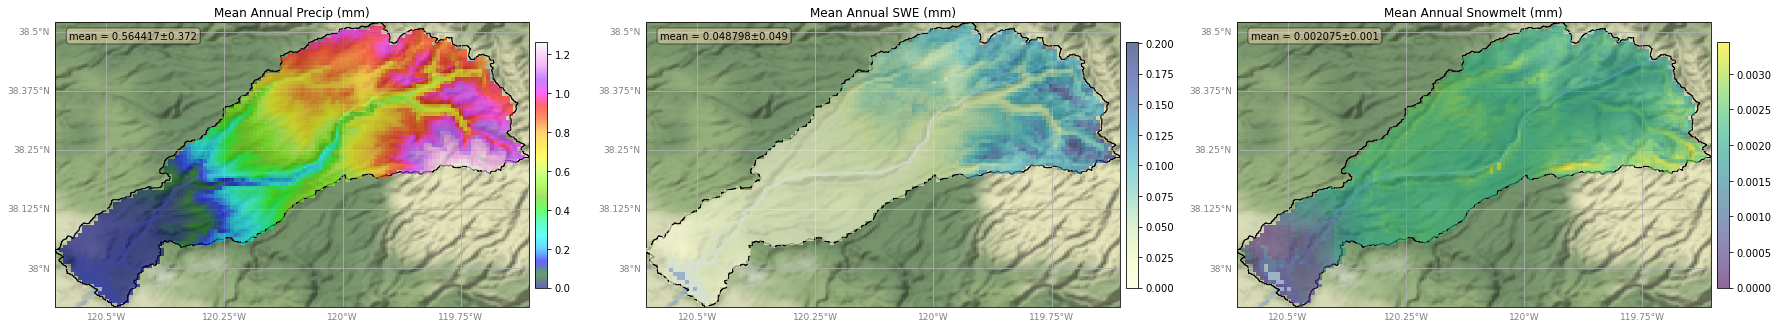

100%|██████████| 10/10 [01:53<00:00, 11.34s/it]


<Figure size 432x288 with 0 Axes>

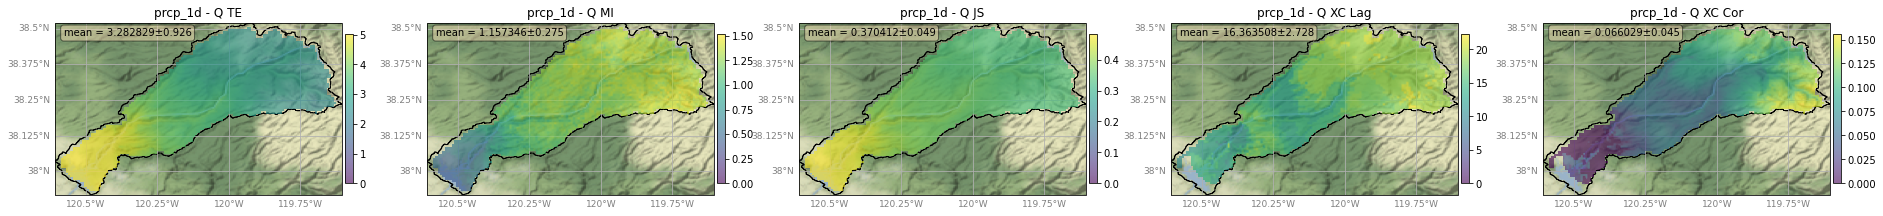

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/NML_prcp_1d_te_ex.tif
wrote ../data/extremes_all/NML_prcp_1d_mi_ex.tif
wrote ../data/extremes_all/NML_prcp_1d_js_ex.tif
wrote ../data/extremes_all/NML_prcp_1d_cor_ex.tif
wrote ../data/extremes_all/NML_prcp_1d_lag_ex.tif


100%|██████████| 10/10 [01:52<00:00, 11.25s/it]


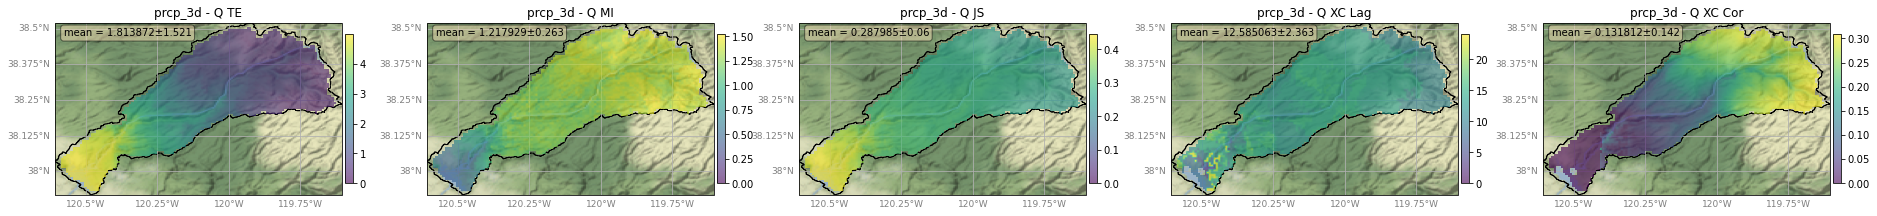

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/NML_prcp_3d_te_ex.tif
wrote ../data/extremes_all/NML_prcp_3d_mi_ex.tif
wrote ../data/extremes_all/NML_prcp_3d_js_ex.tif
wrote ../data/extremes_all/NML_prcp_3d_cor_ex.tif
wrote ../data/extremes_all/NML_prcp_3d_lag_ex.tif


100%|██████████| 10/10 [01:51<00:00, 11.20s/it]


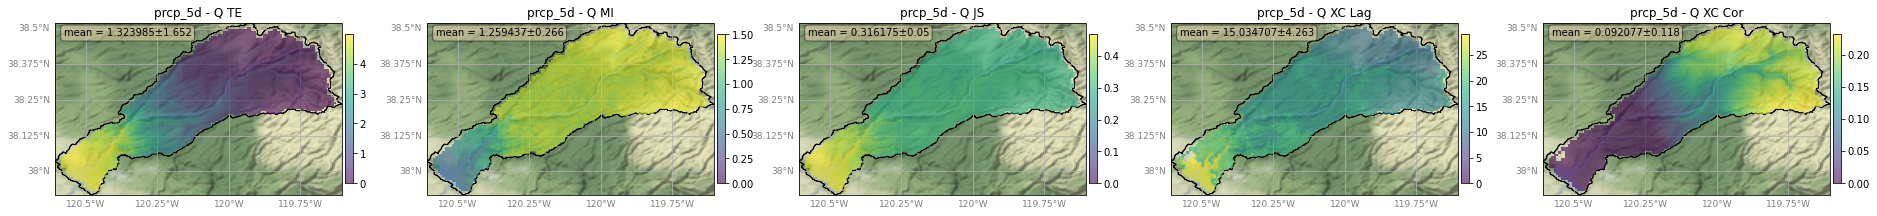

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/NML_prcp_5d_te_ex.tif
wrote ../data/extremes_all/NML_prcp_5d_mi_ex.tif
wrote ../data/extremes_all/NML_prcp_5d_js_ex.tif
wrote ../data/extremes_all/NML_prcp_5d_cor_ex.tif
wrote ../data/extremes_all/NML_prcp_5d_lag_ex.tif


100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


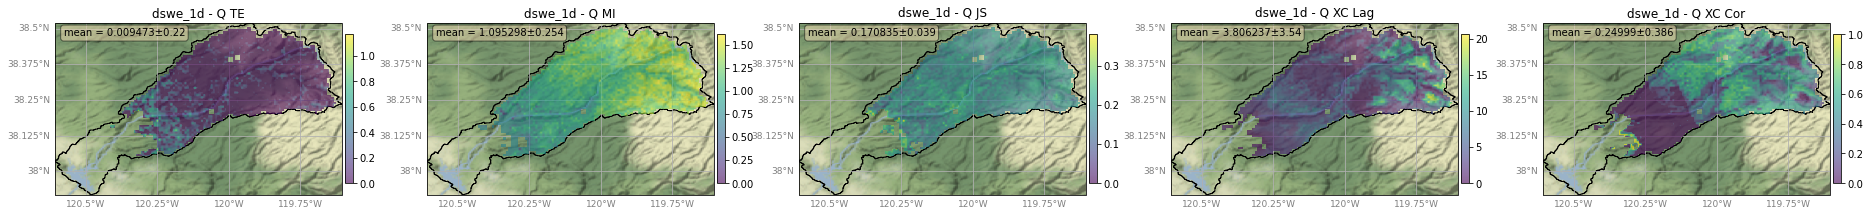

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/NML_dswe_1d_te_ex.tif
wrote ../data/extremes_all/NML_dswe_1d_mi_ex.tif
wrote ../data/extremes_all/NML_dswe_1d_js_ex.tif
wrote ../data/extremes_all/NML_dswe_1d_cor_ex.tif
wrote ../data/extremes_all/NML_dswe_1d_lag_ex.tif


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


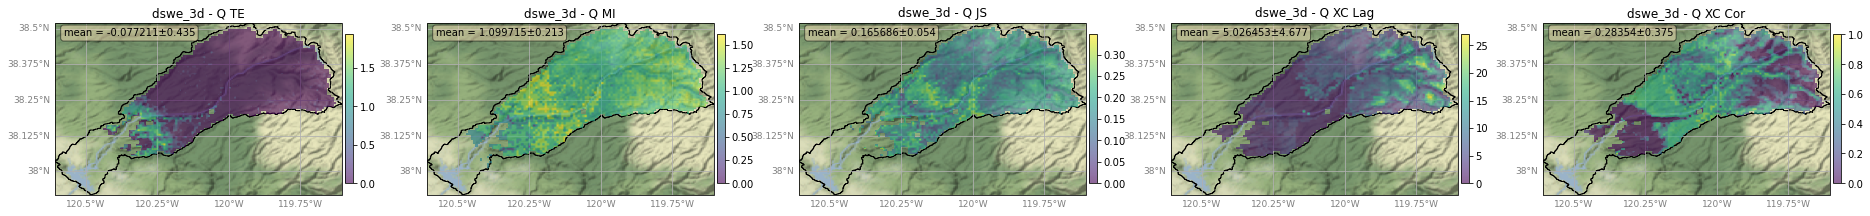

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/NML_dswe_3d_te_ex.tif
wrote ../data/extremes_all/NML_dswe_3d_mi_ex.tif
wrote ../data/extremes_all/NML_dswe_3d_js_ex.tif
wrote ../data/extremes_all/NML_dswe_3d_cor_ex.tif
wrote ../data/extremes_all/NML_dswe_3d_lag_ex.tif


100%|██████████| 10/10 [01:04<00:00,  6.40s/it]


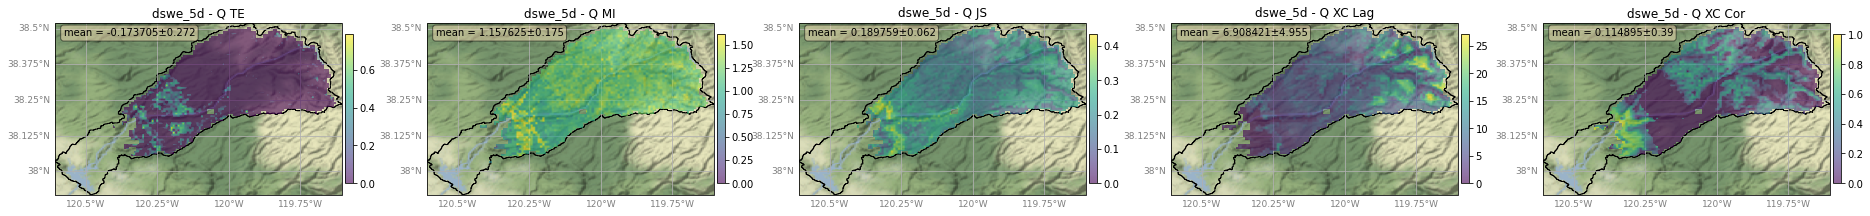

wrote ../data/extremes_all/NML_dswe_5d_te_ex.tif
wrote ../data/extremes_all/NML_dswe_5d_mi_ex.tif
wrote ../data/extremes_all/NML_dswe_5d_js_ex.tif
wrote ../data/extremes_all/NML_dswe_5d_cor_ex.tif
wrote ../data/extremes_all/NML_dswe_5d_lag_ex.tif
************************************************************
Processing catchment: FEATHER R
With reservoir terminus: ORO


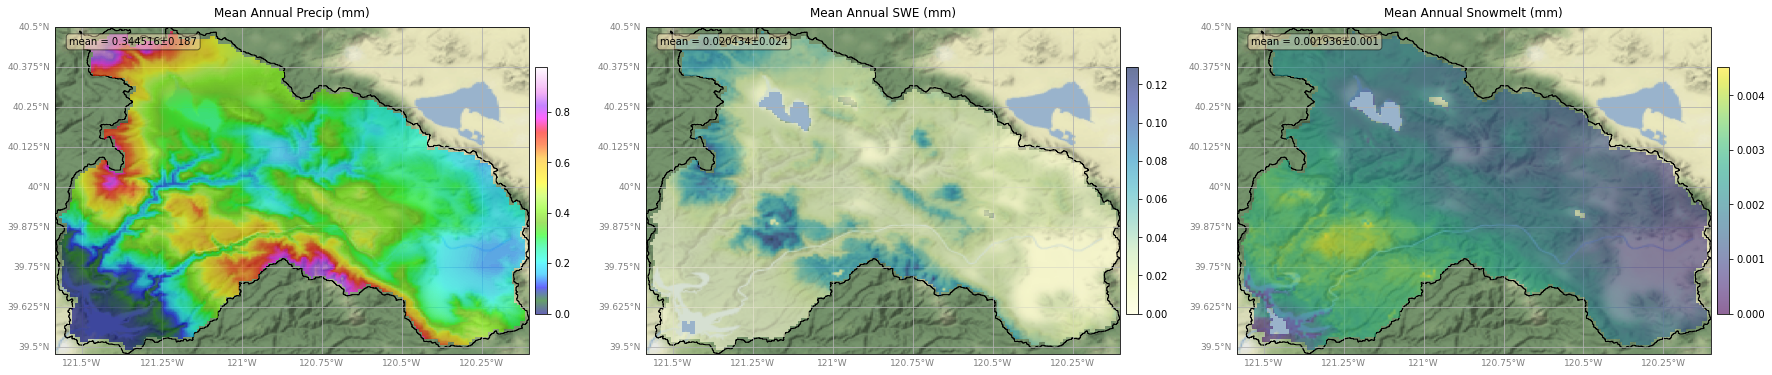

100%|██████████| 10/10 [07:28<00:00, 44.84s/it]


<Figure size 432x288 with 0 Axes>

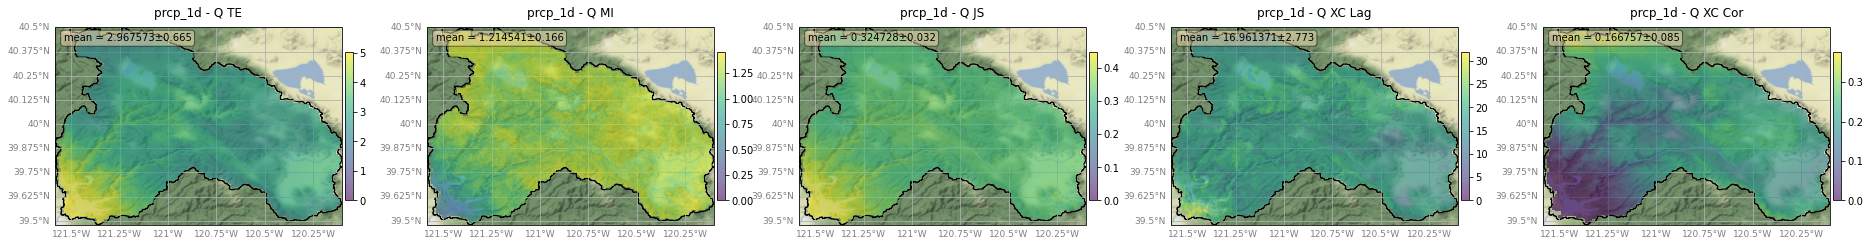

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/ORO_prcp_1d_te_ex.tif
wrote ../data/extremes_all/ORO_prcp_1d_mi_ex.tif
wrote ../data/extremes_all/ORO_prcp_1d_js_ex.tif
wrote ../data/extremes_all/ORO_prcp_1d_cor_ex.tif
wrote ../data/extremes_all/ORO_prcp_1d_lag_ex.tif


100%|██████████| 10/10 [07:28<00:00, 44.82s/it]


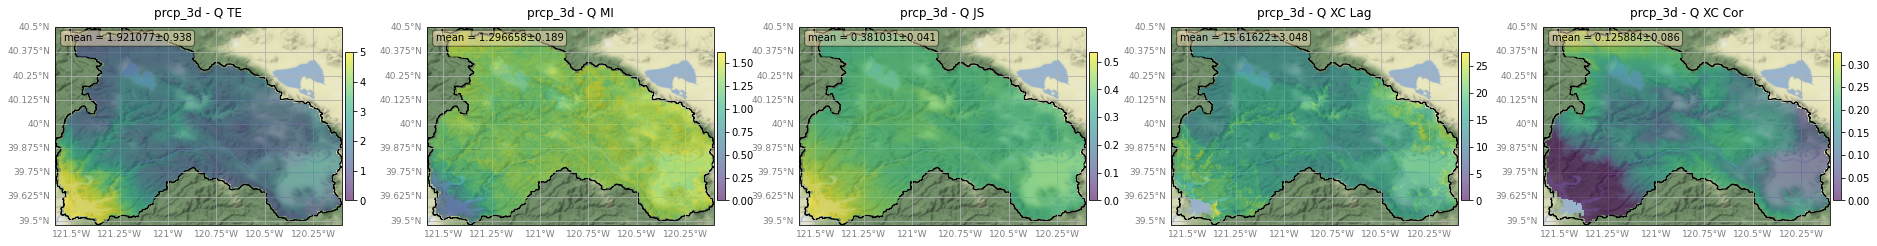

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/ORO_prcp_3d_te_ex.tif
wrote ../data/extremes_all/ORO_prcp_3d_mi_ex.tif
wrote ../data/extremes_all/ORO_prcp_3d_js_ex.tif
wrote ../data/extremes_all/ORO_prcp_3d_cor_ex.tif
wrote ../data/extremes_all/ORO_prcp_3d_lag_ex.tif


100%|██████████| 10/10 [07:27<00:00, 44.78s/it]


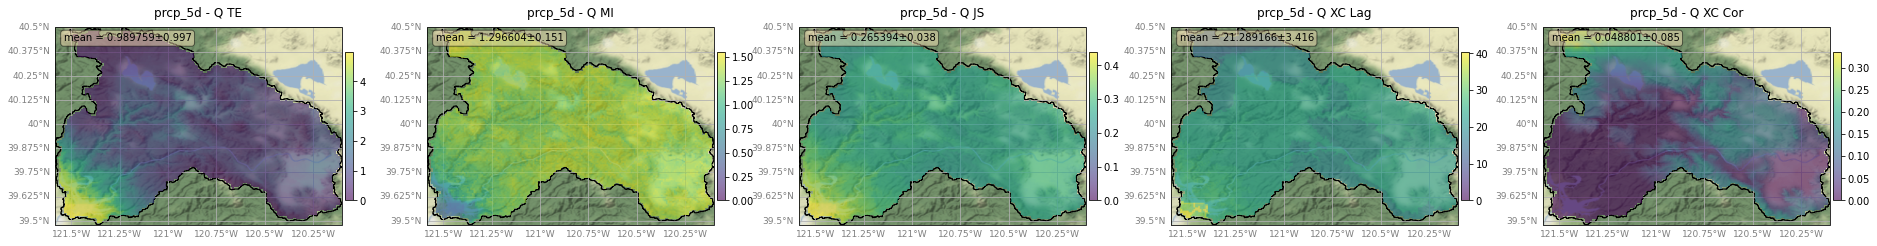

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/ORO_prcp_5d_te_ex.tif
wrote ../data/extremes_all/ORO_prcp_5d_mi_ex.tif
wrote ../data/extremes_all/ORO_prcp_5d_js_ex.tif
wrote ../data/extremes_all/ORO_prcp_5d_cor_ex.tif
wrote ../data/extremes_all/ORO_prcp_5d_lag_ex.tif


100%|██████████| 10/10 [07:02<00:00, 42.21s/it]


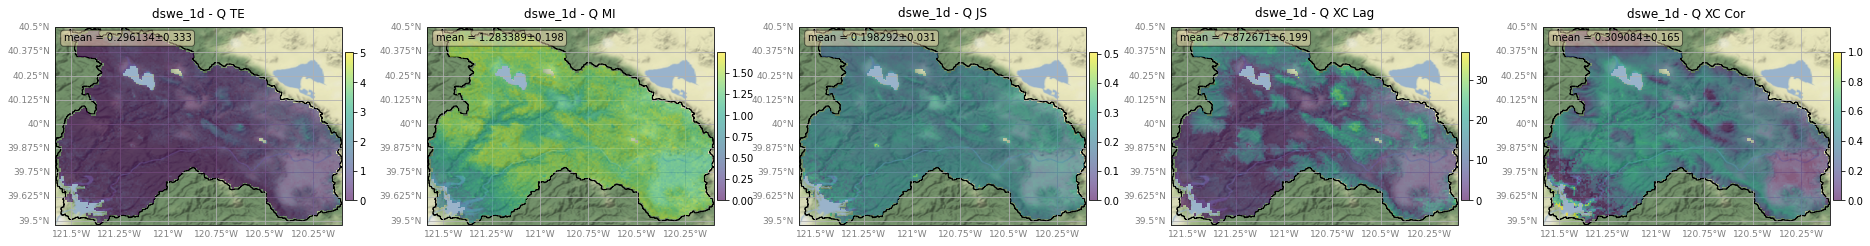

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/ORO_dswe_1d_te_ex.tif
wrote ../data/extremes_all/ORO_dswe_1d_mi_ex.tif
wrote ../data/extremes_all/ORO_dswe_1d_js_ex.tif
wrote ../data/extremes_all/ORO_dswe_1d_cor_ex.tif
wrote ../data/extremes_all/ORO_dswe_1d_lag_ex.tif


100%|██████████| 10/10 [06:44<00:00, 40.45s/it]


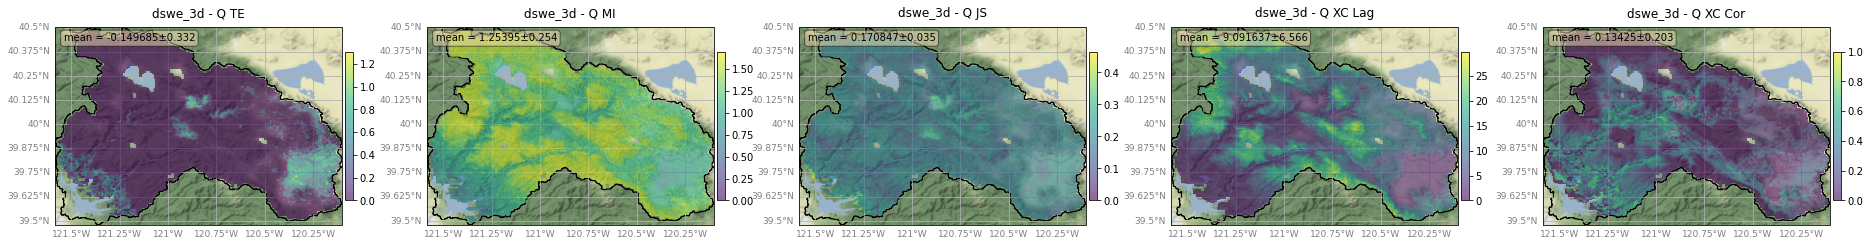

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/ORO_dswe_3d_te_ex.tif
wrote ../data/extremes_all/ORO_dswe_3d_mi_ex.tif
wrote ../data/extremes_all/ORO_dswe_3d_js_ex.tif
wrote ../data/extremes_all/ORO_dswe_3d_cor_ex.tif
wrote ../data/extremes_all/ORO_dswe_3d_lag_ex.tif


100%|██████████| 10/10 [05:13<00:00, 31.37s/it]


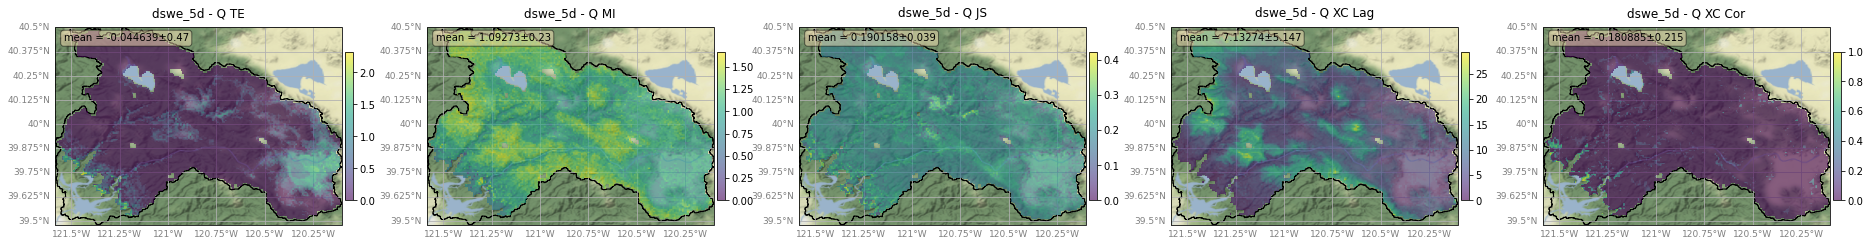

wrote ../data/extremes_all/ORO_dswe_5d_te_ex.tif
wrote ../data/extremes_all/ORO_dswe_5d_mi_ex.tif
wrote ../data/extremes_all/ORO_dswe_5d_js_ex.tif
wrote ../data/extremes_all/ORO_dswe_5d_cor_ex.tif
wrote ../data/extremes_all/ORO_dswe_5d_lag_ex.tif
************************************************************
Processing catchment: AMERICAN R
With reservoir terminus: FOL


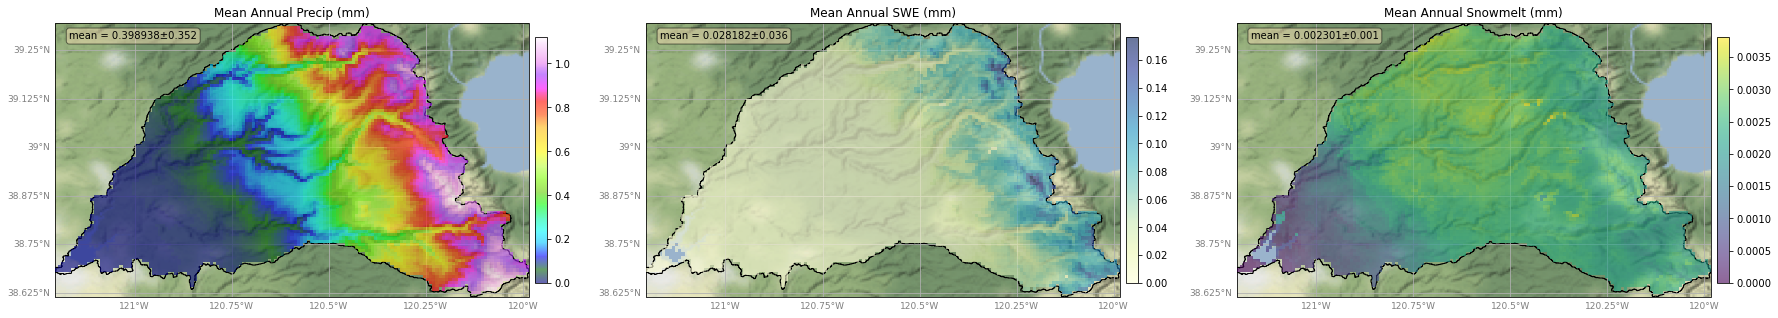

100%|██████████| 10/10 [03:53<00:00, 23.36s/it]


<Figure size 432x288 with 0 Axes>

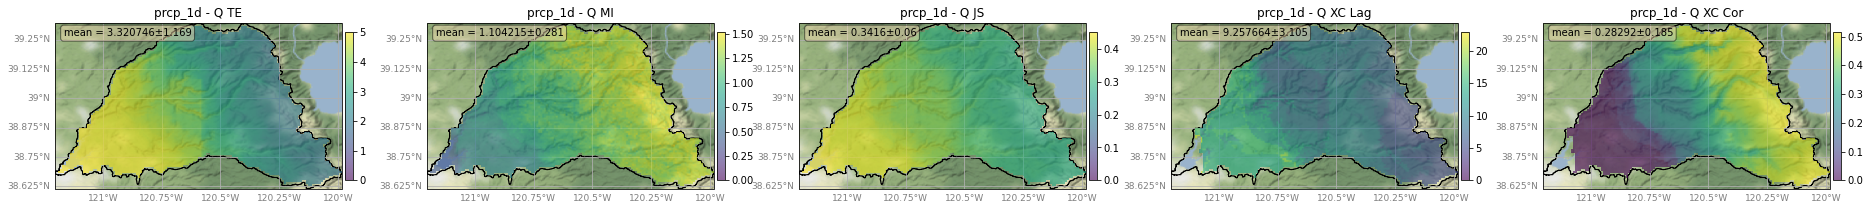

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/FOL_prcp_1d_te_ex.tif
wrote ../data/extremes_all/FOL_prcp_1d_mi_ex.tif
wrote ../data/extremes_all/FOL_prcp_1d_js_ex.tif
wrote ../data/extremes_all/FOL_prcp_1d_cor_ex.tif
wrote ../data/extremes_all/FOL_prcp_1d_lag_ex.tif


100%|██████████| 10/10 [03:52<00:00, 23.27s/it]


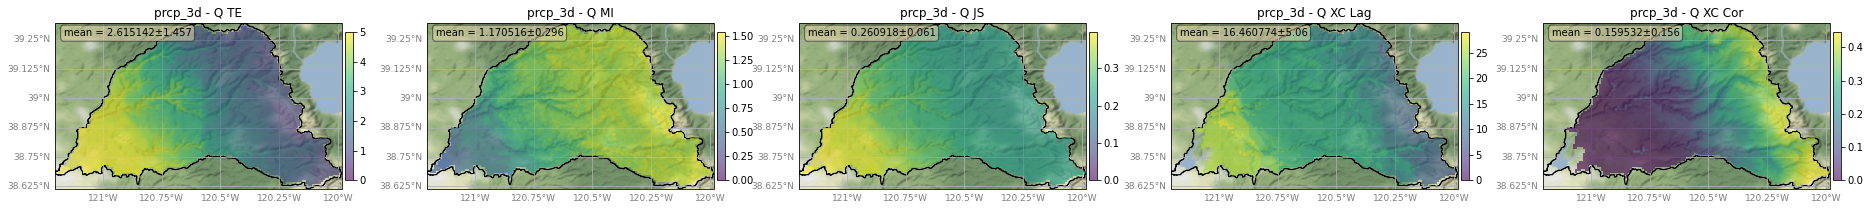

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/FOL_prcp_3d_te_ex.tif
wrote ../data/extremes_all/FOL_prcp_3d_mi_ex.tif
wrote ../data/extremes_all/FOL_prcp_3d_js_ex.tif
wrote ../data/extremes_all/FOL_prcp_3d_cor_ex.tif
wrote ../data/extremes_all/FOL_prcp_3d_lag_ex.tif


100%|██████████| 10/10 [05:43<00:00, 34.34s/it]


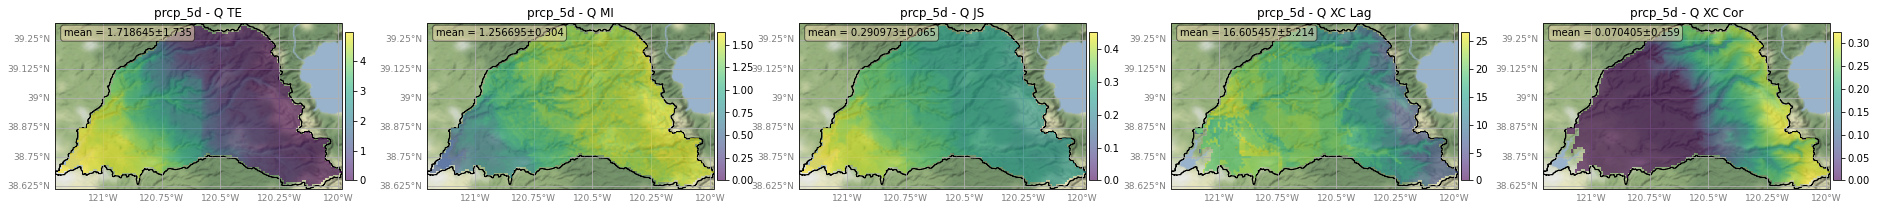

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/FOL_prcp_5d_te_ex.tif
wrote ../data/extremes_all/FOL_prcp_5d_mi_ex.tif
wrote ../data/extremes_all/FOL_prcp_5d_js_ex.tif
wrote ../data/extremes_all/FOL_prcp_5d_cor_ex.tif
wrote ../data/extremes_all/FOL_prcp_5d_lag_ex.tif


100%|██████████| 10/10 [04:56<00:00, 29.64s/it]


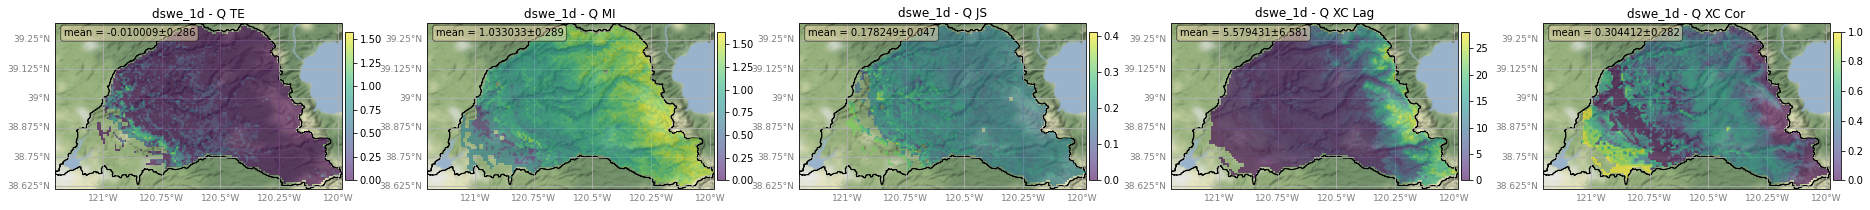

  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/FOL_dswe_1d_te_ex.tif
wrote ../data/extremes_all/FOL_dswe_1d_mi_ex.tif
wrote ../data/extremes_all/FOL_dswe_1d_js_ex.tif
wrote ../data/extremes_all/FOL_dswe_1d_cor_ex.tif
wrote ../data/extremes_all/FOL_dswe_1d_lag_ex.tif


100%|██████████| 10/10 [02:36<00:00, 15.61s/it]


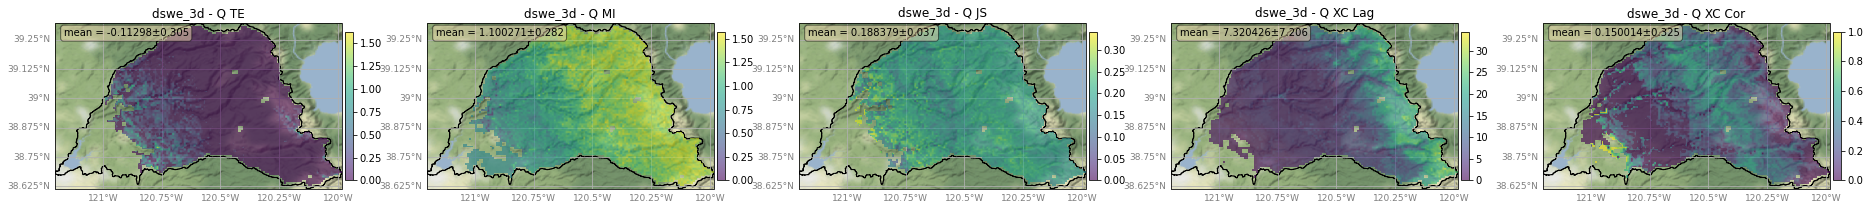

wrote ../data/extremes_all/FOL_dswe_3d_te_ex.tif
wrote ../data/extremes_all/FOL_dswe_3d_mi_ex.tif
wrote ../data/extremes_all/FOL_dswe_3d_js_ex.tif
wrote ../data/extremes_all/FOL_dswe_3d_cor_ex.tif


  0%|          | 0/10 [00:00<?, ?it/s]

wrote ../data/extremes_all/FOL_dswe_3d_lag_ex.tif


 60%|██████    | 6/10 [11:56<09:08, 137.19s/it]

In [ ]:
# Main routine 

for idx, x in gdf[5:].iterrows():
    print("****" * 15)
    # get catchment ID
    stn_id = x['stid']
    # Read catchment shapefile 
    catch_shp = "../shape/{}.shp".format(stn_id)
    # Needed for plotting
    shape_feature = ShapelyFeature(Reader(catch_shp).geometries(),
                            ccrs.PlateCarree(), edgecolor='black', facecolor = 'none')

    print("Processing catchment: {}".format( x['catch_name']))
    print("With reservoir terminus: {}".format(stn_id))

    # Set filepaths for hydro data 
    resfn = os.path.join('../data/res_inflow/{}_res.csv'.format(stn_id))
    swestack_fn = os.path.join('../data/swe/{}_swe.npy'.format(stn_id))
    meltstack_fn = os.path.join('../data/smlt/{}_smlt.npy'.format(stn_id))
    pstack_fn = os.path.join('../data/plqd/{}_plqd.npy'.format(stn_id))
    
    # Get the daily reservoir inflow
    if not os.path.exists(resfn):
        try:
            inflow = rs.col_to_dt(get_res_data(stn_id, startdate, enddate))
            inflow.to_csv(resfn)
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        inflow = rs.col_to_dt(pd.read_csv(resfn))
        if len(inflow) == 0:
            print("no data for {}".format(stn_id))
            continue

    # Get the SWE
    swestack = np.load(swestack_fn)
    swestack = swestack / 1000. # apply scaling factor 
    swevals = [swestack[:,:,t] for t in range(0, swestack.shape[2])]

    # Load dSWE
    dswe_unfilt = np.load(meltstack_fn)
    dswe = dswe_unfilt[:,:,-swestack.shape[2]:] # chop off the many trailing nans? 
    dswe = dswe / 100000. # apply scaling factor 
    dswevals = [dswe[:,:,t] for t in range(0, dswe.shape[2])]

    # compute hte rolling 3 and 5 day sums via convolution 
    conv_win_3d = np.ones(3)
    dswe_rolling_3d = np.apply_along_axis(lambda m: np.convolve(m, conv_win_3d, mode='full'), axis=2, arr=dswe)
    dswe_3d = dswe_rolling_3d[:,:,2:]
    dswevals_3d = [dswe_3d[:,:,t] for t in range(0, dswe_3d.shape[2])]

    conv_win_5d = np.ones(5)
    dswe_rolling_5d = np.apply_along_axis(lambda m: np.convolve(m, conv_win_5d, mode='full'), axis=2, arr=dswe)
    dswe_5d = dswe_rolling_5d[:,:,4:]
    dswevals_5d = [dswe_5d[:,:,t] for t in range(0, dswe_5d.shape[2])]

    # Load Precip
    pstack_unfilt = np.load(pstack_fn)
    pstack = pstack_unfilt[:,:,-swestack.shape[2]:] # chop off the many trailing nans? 
    pstack = pstack / 10. # apply scaling factor 
    pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]

    # compute hte rolling 3 and 5 day sums via convolution 
    p_rolling_3d = np.apply_along_axis(lambda m: np.convolve(m, conv_win_3d, mode='full'), axis=2, arr=pstack)
    p_3d = p_rolling_3d[:,:,:-2]
    pvals_3d = [p_3d[:,:,t] for t in range(0, p_3d.shape[2])]

    p_rolling_5d = np.apply_along_axis(lambda m: np.convolve(m, conv_win_5d, mode='full'), axis=2, arr=pstack)
    p_5d = p_rolling_5d[:,:,:-4]
    pvals_5d = [p_5d[:,:,t] for t in range(0, p_5d.shape[2])]

    # Make a watershed mean df
    shed_ts  = inflow.loc[dt_idx[0]:dt_idx[-1]]
    swevals = np.array([np.nansum(x) for x in [swestack[:,:,t] for t in range(0, swestack.shape[2])]])
    dswevals = np.array([np.nansum(x) for x in [dswe[:,:,t] for t in range(0, dswe.shape[2])]])
    pvals = np.array([np.nansum(x) for x in [pstack[:,:,t] for t in range(0, pstack.shape[2])]])

    ######## Preprocess and EDA #########
    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')
        
    # Get annual mean ims 
    pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]
    
    # Compute annual means
    annual_pmean = pmean 
    annual_swemean = swemean
    annual_dswemean = dswemean 
        
    # Get annual mean ims 
    pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]
    pmean[pmean == 0] = np.nan
    
    # Plot annual means (mask swe pixels < 0.1mm/y)
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (30,12), subplot_kw={'projection': ccrs.PlateCarree()})

    plot_basemaps(annual_pmean, "Mean Annual Precip (mm)", cmap = 'gist_ncar', ax = axes[0], latlabels = True, lonlabels = True )
    plot_basemaps(annual_swemean, "Mean Annual SWE (mm)", cmap = 'YlGnBu', ax = axes[1], latlabels = True, lonlabels = True)
    plot_basemaps(annual_dswemean, "Mean Annual Snowmelt (mm)", cmap = 'viridis', ax = axes[2], latlabels = True, lonlabels = True )
    plt.show()
    plt.savefig("../figures/{}_means.png".format(stn_id))

    # Get a df for later filtering
    shed_ts  = inflow.loc[dt_idx[0]:dt_idx[-1]]
    swevals = np.array([np.nansum(x) for x in [swestack[:,:,t] for t in range(0, swestack.shape[2])]])
    dswevals = np.array([np.nansum(x) for x in [dswe[:,:,t] for t in range(0, dswe.shape[2])]])
    pvals = np.array([np.nansum(x) for x in [pstack[:,:,t] for t in range(0, pstack.shape[2])]])

    shed_ts['prcp_1d'] = pvals
    shed_ts['dswe_1d'] = dswevals
    
    # calc watershed avg rolling sums
    shed_ts['prcp_3d'] = shed_ts['prcp_1d'].rolling(3).sum()
    shed_ts['dswe_3d'] = shed_ts['dswe_1d'].rolling(3).sum()

    shed_ts['prcp_5d'] = shed_ts['prcp_1d'].rolling(5).sum()
    shed_ts['dswe_5d'] = shed_ts['dswe_1d'].rolling(5).sum()

    ########### Main Routine: Info Theory #############

    # Setup out dirs
    # For tables
    results_folder = 'extremes_all'
    results_outpath = os.path.join("../data/",results_folder)
    # for rasters
    rasters_outpath = os.path.join("../rasters/", results_folder)

    if not os.path.exists(results_outpath):
        os.mkdir(results_outpath)
        
    if not os.path.exists(rasters_outpath):
        os.mkdir(rasters_outpath)

    ############## Extremes of 1,3,5d #############

    # for the extremes (1d, 3d, 5d), find the dates of the events that exceed the 99th %ile, and rank based on value for N events. 
    num_events = 10

    p_ev_1d = shed_ts[shed_ts['prcp_1d']>= np.nanpercentile(shed_ts['prcp_1d'], 99)].sort_values(by = 'prcp_1d', ascending = True).index[:num_events]
    d_ev_1d = shed_ts[shed_ts['dswe_1d']>= np.nanpercentile(shed_ts['dswe_1d'], 99)].sort_values(by = 'dswe_1d', ascending = True).index[:num_events]

    p_ev_3d = shed_ts[shed_ts['prcp_3d']>= np.nanpercentile(shed_ts['prcp_3d'], 99)].sort_values(by = 'prcp_3d', ascending = True).index[:num_events]
    d_ev_3d = shed_ts[shed_ts['dswe_3d']>= np.nanpercentile(shed_ts['dswe_3d'], 99)].sort_values(by = 'dswe_3d', ascending = True).index[:num_events]

    p_ev_5d = shed_ts[shed_ts['prcp_5d']>= np.nanpercentile(shed_ts['prcp_5d'], 99)].sort_values(by = 'prcp_5d', ascending = True).index[:num_events]
    d_ev_5d = shed_ts[shed_ts['dswe_5d']>= np.nanpercentile(shed_ts['dswe_5d'], 99)].sort_values(by = 'dswe_5d', ascending = True).index[:num_events]

    ############# MAIN ROUTINE #############
    imstack_lookup = {
    'prcp_1d': pstack,
    'prcp_3d': p_3d,
    'prcp_5d': p_5d,
    'dswe_1d': dswe,
    'dswe_3d': dswe_3d,
    'dswe_5d': dswe_5d}

    # Zip together the dates we defined by thresholding with the keys to the relevant arrays 
    iterdict = dict(zip(list(imstack_lookup.keys()),[p_ev_1d,p_ev_3d,p_ev_5d,d_ev_1d,d_ev_3d,d_ev_5d]))

    for k,v in iterdict.items():
        dates = v
        stack = imstack_lookup[k]

        # Wrappers for main routines 
        mi_out, js_out, te_out = calc_it_ev_means(dates, stack)
        cor_out, lag_out = calc_xc_ev_means(dates, stack)

        # Plot
        fig, axes = plt.subplots(nrows=1, ncols=5,figsize = (32,8), subplot_kw={'projection': ccrs.PlateCarree()})
        plot_basemaps(te_out,"{} - Q TE".format(k),cmap = 'viridis', ax = axes[0])
        plot_basemaps(mi_out,"{} - Q MI".format(k),cmap = 'viridis', ax = axes[1])
        plot_basemaps(js_out,"{} - Q JS".format(k),cmap = 'viridis', ax = axes[2])
        plot_basemaps(lag_out,"{} - Q XC Lag".format(k),cmap = 'viridis', ax = axes[3])
        plot_basemaps(cor_out,"{} - Q XC Cor".format(k),cmap = 'viridis', ax = axes[4])

        plt.subplots_adjust(wspace = 0.25, hspace = 0.15)
        plt.savefig("../figures/{}_ex_{}.png".format(stn_id,k))
        plt.show()

        rs.write_raster(te_out, gp.read_file(catch_shp),os.path.join(results_outpath,"{}_{}_te_ex.tif".format(stn_id,k)))
        rs.write_raster(mi_out, gp.read_file(catch_shp),os.path.join(results_outpath,"{}_{}_mi_ex.tif".format(stn_id,k)))
        rs.write_raster(js_out, gp.read_file(catch_shp),os.path.join(results_outpath,"{}_{}_js_ex.tif".format(stn_id,k)))                       
        rs.write_raster(cor_out, gp.read_file(catch_shp),os.path.join(results_outpath,"{}_{}_cor_ex.tif".format(stn_id,k)))
        rs.write_raster(lag_out, gp.read_file(catch_shp),os.path.join(results_outpath,"{}_{}_lag_ex.tif".format(stn_id,k)))
